# Snippets

short scripts worth keeping

In [2]:
%matplotlib inline
from collections import defaultdict
from constants import *
from os import listdir
from os.path import isfile, join
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
pd.options.display.max_rows = 2001

-----

## Wikipedia - extracting phrases from titles

In [6]:
titles = []

def unique(ser):
    return ser.dropna().str.strip().unique()

f = 'dewiki_links.pickle'
dfl = pd.read_pickle(join(ETL_PATH, f))
f = 'dewiki_categories.pickle'
dfc = pd.read_pickle(join(ETL_PATH, f))

print(1, end=', ')
titles.append(unique(dfl.norm))
print(2, end=', ')
titles.append(unique(dfl.category))
print(3, end=', ')
titles.append(unique(dfc.category))
del dfc, dfl
gc.collect()
gc.collect()

pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(ETL_PATH)
                if (isfile(join(ETL_PATH, f)) and pattern.match(f))])

for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    f = join(ETL_PATH, corpus + '.pickle')
    titles.append(unique(pd.read_pickle(f)[TITLE]))

print(titles)
df = pd.DataFrame(np.unique(np.hstack(titles)), columns=['phrase'])
del titles
gc.collect()
gc.collect()

print(df.head())
df['length'] = df.phrase.apply(lambda x: x.count(' ') + 1)
df = df[(df.length > 1) & (df.length < 6)]
r = re.compile(r'^[a-zA-Z0-9_äöüÄÖÜß]')
df = df[df.phrase.str.match(r)]

df = df['phrase']
print('expand')
df = df.str.split(' ', expand=True)
print('write')
df.to_pickle(join(ETL_PATH, 'dewiki_phrases.pickle'))

1, 2, 3, dewiki_01_0, dewiki_01_1, dewiki_01_2, dewiki_01_3, dewiki_02_0, dewiki_02_1, dewiki_03, dewiki_04, dewiki_05, dewiki_06, dewiki_07, dewiki_08, dewiki_09, dewiki_10, dewiki_11, dewiki_12, dewiki_13, dewiki_14, dewiki_15, dewiki_16, dewiki_17, dewiki_18, dewiki_19, dewiki_20, dewiki_21, dewiki_22, dewiki_23, dewiki_24, dewiki_25, dewiki_26, dewiki_27, dewiki_28, dewiki_29, dewiki_30, dewiki_31, dewiki_32, dewiki_33, dewiki_34, dewiki_35, dewiki_36, dewiki_37, [array(['Manier', 'New York City', 'Radioaktivität', ..., 'Clara Eppert',
       'Slatiňany', ':cs:Stažená_hrdla'], dtype=object), array(['Stil', 'Regisseur', '2000', ..., 'Buddhism', 'Zwischenwasser',
       'Teurow'], dtype=object), array(['Fiktive Person', 'Pseudonym', 'Sammelpseudonym', ...,
       'Obusier de 520 modèle 1916', 'Rabštejnská Lhota', 'Flaschenspiel'],
      dtype=object), array(['Alan Smithee', 'Actinium', 'Ang Lee', ..., 'Klodzko',
       'Finnlandschwedisch', 'Oratorium'], dtype=object), array(['Hans P

-----

## Wikipedia - replace document hashes with updates

In [ ]:
pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(ETL_PATH)
                if (isfile(join(ETL_PATH, f)) and pattern.match(f))])

mappings = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus)
    
    f = join(NLP_PATH, corpus + '_nlp.pickle')
    dfnlp = (
        pd.read_pickle(f)
        .groupby(HASH).head(1)[[HASH, TEXT]]
        .reset_index()
    )
    f = join(ETL_PATH, corpus + '.pickle')
    dfetl = (
        pd.read_pickle(f)
        .astype({
            DATASET: "category",
            SUBSET: "category", 
        })
        .reset_index()
        .join(dfnlp, rsuffix='_nlp')
    )
    dfjoin = dfetl[[HASH, TITLE, 'hash_nlp', 'text_nlp']].copy()
    dfjoin['equal_start'] = dfjoin.apply(lambda x: x.title.startswith(x.text_nlp), axis=1)
    #dfjoin['first_token'] = None
    #dfjoin['first_token'] = dfjoin.title.str.split(expand=True)
    #dfjoin['equal'] = (dfjoin.text_nlp == dfjoin.first_token)
    assert dfjoin.equal_start.sum() == len(dfjoin)
    dfetl = (
        dfetl
        .set_index('hash_nlp', drop=True)
        .drop(['text_nlp', 'hash', 'index'], axis=1)
    )
    dfetl.to_pickle(f)
    mappings.append(dfjoin[['hash', 'hash_nlp']])
    
dfmap = pd.concat(mappings)
dfmap = dfmap.set_index(HASH)['hash_nlp']
dfmap.to_pickle(join(ETL_PATH, 'dewiki_hashmap.pickle'))
pd.read_pickle(join(ETL_PATH, 'dewiki_hashmap.pickle'))

In [ ]:
def replace_docid(f):
    print(f)
    df = (
        pd.read_pickle(join(ETL_PATH, f))
        .join(dfmap, on='doc_id')
        .drop('doc_id', axis=1)
    )
    df.to_pickle(join(ETL_PATH, f))

replace_docid('dewiki_categories.pickle')
replace_docid('dewiki_links.pickle')

-----

## Fix sent_idx in NLP and SIMPLE

In [ ]:
def fix_sent_idx(f, store=False):
        print("read", f)
        df = pd.read_pickle(f)
        columns = df.columns.tolist()
        len_old = len(df)
        size_old = df.size
        
        # create a count for each document
        df_group = pd.DataFrame(df.groupby(HASH).head(1)[HASH]).reset_index(drop=True)
        df_group['count'] = df_group.index
        
        # append count to original DataFrame
        df = df.merge(df_group[[HASH, 'count']], on=HASH)
        
        # add document count to sent_idx
        df['sent_idx'] += df['count']
        df = df[columns]
        len_new = len(df)
        size_new = df.size
        assert len_old == len_new
        assert size_old == size_new
        
        if store:
            print("write", f)
            df.to_pickle(f)
            
        return df

In [ ]:
# apply on nlp
path = NLP_PATH
number = 2
files = sorted([f for f in listdir(path) if isfile(join(path, f))], key=lambda s: s.lower())
for name in files[:number]:
    f = join(path, name)
    fix_sent_idx(f, store=False)

In [ ]:
# apply on simple ... will not work. better redo simple
path = SMPL_PATH
number = 2
files = sorted([f for f in listdir(path) if isfile(join(path, f))], key=lambda s: s.lower())
for name in files[:number]:
    f = join(path, name)
    df = fix_sent_idx(f, store=False)

In [ ]:
pd.options.display.max_rows = 2005
df.loc[1000:3000, [HASH, SENT_IDX, TOK_IDX, TOKEN]]

-----

## Restoring original document hashes

for *_simple files (after accidental dtype conversion during phrase extraction)

In [ ]:
corpus = 'FAZ'
f = join(NLP_PATH, corpus + '_nlp.pickle')
dfn = pd.read_pickle(f)
f = join(SMPL_PATH, corpus + '_simple.pickle')
dfs = pd.read_pickle(f)

In [ ]:
pd.options.display.max_rows = 2005
dfn.loc[0:500, [HASH, SENT_IDX, TOK_IDX, TOKEN]]

In [ ]:
dfs = dfs.rename(columns={'hash': 'hash_wrong'})
dfs[0:300]
# hm this is bad: first word of document is in wrong order - better redo simple

In [ ]:
#dfs_u = dfs[SENT_IDX].unique()
dfng = dfn.groupby(['hash', SENT_IDX]).head(1)
dfsg = dfs.groupby(['hash_wrong', SENT_IDX]).head(1)

In [ ]:
dfsg[['hash_wrong', SENT_IDX, POS]]

In [ ]:
# 1) joining on index: -> not working
# 2) joining 
dfx = dfs.join(dfn[HASH])
dfx['diff'] = (dfx['hash_wrong'] - dfx[HASH]).abs()
dfx[[HASH, 'hash_wrong', 'diff']]

In [ ]:
dfx[dfx.POS == 'NPHRASE']

------

## preprocess FAZ

### Join FAZ and FAZ2 and remove duplicates

In [ ]:
fname1 = 'FAZ.pickle'
fpath1 = join(ETL_PATH, fname1)
df1 = pd.read_pickle(fpath1)
fname2 = 'FAZ2.pickle'
fpath2 = join(ETL_PATH, fname2)
df2 = pd.read_pickle(fpath2)

df1['new'] = False
combined = pd.concat([df1, df2])
c1 = combined
c2 = combined[~combined.duplicated(subset=[TITLE])]
c1.shape, c2.shape

In [ ]:
df = c2
del c1, c2, df1, df2
df = df[~df.subset.isin(
    [
        'angst-in-chemnitz-und-arroganz-im-dfb-team-15762511.html',
        'faz-net-sprinter-dumm-aber-sexy-15758998.html',
        'faz-net-sprinter-gehoert-sachsen-noch-zu-deutschland-15760532.html',
        'reise',
        #'rhein-main',
        'sport',
        #'technik-motor',
    ]
)]
df.groupby('subset').describe()

### Find encrypted articles (FAZ)

In [ ]:
# inspect the first entries to create a training set
df['str_len'] = df[TEXT].str.len()
half = df.apply(lambda x: x[TEXT][x['str_len']//2:], axis=1)
half.head(30)

In [ ]:
# the first 25 articles are ok
trainset = df.iloc[:25][TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)
    
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print([encryption_score(string) for string in good])
bad = df.loc[5598736571409986456, TEXT]
print(encryption_score(bad))

In [ ]:
# apply metric on corpus
df['enc_score'] = df[TEXT].apply(encryption_score)
df[[TEXT, 'enc_score']]

In [ ]:
# evaluate results
plt.scatter(df.index, df.enc_score)

In [ ]:
# 300 seems to be a valid limit. We don't loose too many good articles here
outlier1 = df.loc[df.enc_score.between(300, 350), TEXT].tolist()
outlier2 = df.loc[df.enc_score.between(350, 550), TEXT].tolist()
len(outlier1), len(outlier2)

In [ ]:
df = df[df.enc_score <= 300]
len(df)

In [ ]:
df = df.drop(['enc_score', 'str_len', 'new'], axis=1)
df.to_pickle(join(ETL_PATH, 'FAZ_combined.pickle'))
pd.read_pickle(join(ETL_PATH, 'FAZ_combined.pickle')).shape

### balanced sample of dataset (FAZ)

In [ ]:
dfx = df.sample(frac=1, random_state=12345)  # shuffle DataFrame for a random sample
dfx = dfx.groupby('subset').head(2000)
dfx.groupby('subset').describe().enc_score

In [ ]:
dfx.subset.head(25)

In [ ]:
dfx.subset.to_pickle(join(ETL_PATH, 'FAZ_document_sample3.pickle'))

------

## preprocess FOCUS

In [5]:
fname1 = 'FOCUS_cleansed.pickle'
fpath1 = join(ETL_PATH, fname1)
df = pd.read_pickle(fpath1)

### Find bad encoded articles (FOCUS)

In [6]:
# the first 25 articles are ok
trainset = df.iloc[:25][TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)
    
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print([encryption_score(string) for string in good])
#bad = df.loc[5598736571409986456, TEXT]
#print(encryption_score(bad))

defaultdict(<class 'int'>, {'b': 17.0, 'e': 134.0, 'i': 64.0, 'm': 20.0, ' ': 137.0, 'h': 35.0, 'z': 10.0, 'ö': 2.0, 'l': 33.0, '-': 4.0, 'k': 13.0, 'a': 47.0, 'u': 31.0, 'f': 13.0, 's': 53.0, 't': 52.0, 'd': 39.0, 'r': 58.0, 'c': 24.0, 'g': 22.0, 'n': 81.0, 'o': 26.0, '.': 9.0, 'w': 10.0, 'ü': 5.0, 'v': 7.0, ':': 1.0, ',': 6.0, 'p': 11.0, 'ä': 4.0, '8': 0.0, '1': 1.0, '2': 1.0, '0': 1.0, 'j': 1.0, '–': 0.0, 'ß': 1.0, '9': 0.0, '\n': 3.0, 'y': 1.0, '6': 0.0, '5': 0.0, '„': 0.0, '“': 0.0, '?': 0.0, '’': 0.0, '7': 0.0, 'x': 0.0, '(': 0.0, ')': 0.0, '*': 0.0, '3': 0.0, '4': 0.0, 'q': 0.0, '&': 0.0, ';': 0.0, '"': 0.0, '!': 0.0, '@': 0.0, '/': 0.0, "'": 0.0, '+': 0.0, 'é': 0.0})
[213, 172, 158, 238, 196, 181, 185, 116, 278, 96, 233, 195, 109, 148, 179, 174, 185, 225, 174, 153]


In [ ]:
# apply metric on corpus
df['enc_score'] = df[TEXT].apply(encryption_score)
df[[TEXT, 'enc_score']]

In [ ]:
# evaluate results
plt.scatter(df.index, df.enc_score)

In [ ]:
# 300 seems to be a valid limit. We don't loose too many good articles here
outlier1 = df.loc[df.enc_score.between(300, 500), TEXT].tolist()
outlier2 = df.loc[df.enc_score.between(400, 3000), TEXT].tolist()
len(outlier1), len(outlier2)

In [ ]:
outlier2

In [ ]:
df.groupby('subset').describe().enc_score

In [ ]:
df = df[df.enc_score <= 300]
len(df)

In [ ]:
df = df.drop(['enc_score'], axis=1)
df.to_pickle(join(ETL_PATH, 'FOCUS_cleansed.pickle'))
pd.read_pickle(join(ETL_PATH, 'FOCUS_cleansed.pickle')).shape

### balanced sample of dataset (FOCUS)

In [ ]:
dfx = df.sample(frac=1, random_state=12345)  # shuffle DataFrame for a random sample
dfx = dfx.groupby('subset').head(2000)
dfx.groupby('subset').describe()

In [ ]:
dfx.subset.to_pickle(join(ETL_PATH, 'FOCUS_document_sample3.pickle'))

### apply cleansing to nlp dataframe

In [ ]:
corpus = 'FAZ_combined'
f = join(ETL_PATH, corpus + '.pickle')
dfetl = pd.read_pickle(f)
corpus = 'FOCUS_nlp'
f = join(NLP_PATH, corpus + '.pickle')
dfnlp = pd.read_pickle(f)

In [ ]:
# remove problematic formatted articles
ev = np.unique(dfetl.index.values)
nv = np.unique(dfnlp.hash.values)
print(ev.size, nv.size)
print((np.union1d(ev, nv)).size, (np.intersect1d(ev, nv)).size)

dfnlpx = dfnlp[dfnlp.hash.isin(ev)]
print(dfnlpx.shape, dfnlp.shape)
print(dfnlpx.groupby(HASH).head(1).shape)

In [ ]:
# save
corpus = 'FOCUS_cleansed_nlp'
f = join(NLP_PATH, corpus + '.pickle')
dfnlpx.to_pickle(f)

-------

## preprocess Wikipedia

### Find bad encoded articles (Wikipedia)

In [1]:
pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(ETL_PATH)
                if (isfile(join(ETL_PATH, f)) and pattern.match(f))])

In [2]:
# take samples from the corpus as training set
samples = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(ETL_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    df = df.loc[df.subset == 'ARTICLE']
    df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    sample_size = len(df) // 5_000
    print(len(df), sample_size)
    samples.append(df[[TITLE, TEXT]].sample(sample_size, random_state=1))

samples = pd.concat(samples)

dewiki_01_0, 20763 4
dewiki_01_1, 17477 3
dewiki_01_2, 18986 3
dewiki_01_3, 18505 3
dewiki_02_0, 36191 7
dewiki_02_1, 35342 7
dewiki_03, 68750 13
dewiki_04, 66730 13
dewiki_05, 63691 12
dewiki_06, 63769 12
dewiki_07, 63046 12
dewiki_08, 58753 11
dewiki_09, 58077 11
dewiki_10, 57080 11
dewiki_11, 57510 11
dewiki_12, 59642 11
dewiki_13, 58799 11
dewiki_14, 58255 11
dewiki_15, 58331 11
dewiki_16, 58485 11
dewiki_17, 60547 12
dewiki_18, 61059 12
dewiki_19, 58988 11
dewiki_20, 57332 11
dewiki_21, 58544 11
dewiki_22, 57563 11
dewiki_23, 55763 11
dewiki_24, 57419 11
dewiki_25, 54563 10
dewiki_26, 56818 11
dewiki_27, 55053 11
dewiki_28, 52670 10
dewiki_29, 56199 11
dewiki_30, 59595 11
dewiki_31, 59401 11
dewiki_32, 59660 11
dewiki_33, 60684 12
dewiki_34, 61350 12
dewiki_35, 60312 12
dewiki_36, 61468 12
dewiki_37, 52317 10


In [4]:
# remove a few problematic documents from training set
removable = [
    841808810294450851,
    -4692350076498843548,
    -8049734301321653789,
    -4131305296668036145,
    -8810233646059586724,
    2361495353241257464,
    2496670190106332015,
    7370294376993591077,
    -7758054498192490695,
    -4994773231110680494,
    2192724857258762575,
    1420892661644474111,
]
samples = samples[~samples.index.isin(removable)]
trainset = df[TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

defaultdict(<class 'int'>, {'c': 21.0, 'h': 31.0, 'a': 50.0, 'r': 62.0, 'l': 31.0, 'e': 121.0, 's': 50.0, ' ': 135.0, 'v': 7.0, 'u': 30.0, 'g': 22.0, 'n': 72.0, 'i': 63.0, 't': 49.0, 'd': 38.0, 'm': 22.0, 'f': 13.0, 'o': 25.0, 'p': 9.0, ':': 1.0, '\n': 6.0, '(': 2.0, 'ä': 3.0, ')': 2.0, '1': 7.0, '7': 1.0, '5': 1.0, '9': 3.0, '–': 0.0, '8': 2.0, '3': 1.0, ',': 7.0, '-': 3.0, 'k': 11.0, '*': 0.0, '0': 4.0, 'é': 0.0, '4': 1.0, '.': 9.0, 'ü': 4.0, 'w': 10.0, 'b': 16.0, '6': 1.0, '²': 0.0, 'ł': 0.0, 'ż': 0.0, 'y': 2.0, 'z': 8.0, 'ń': 0.0, 'j': 2.0, '2': 3.0, '=': 6.0, 'ß': 1.0, '„': 0.0, '“': 0.0, 'ó': 0.0, '†': 0.0, 'ö': 2.0, ';': 0.0, 'q': 0.0, 'x': 0.0, '&': 0.0, '?': 0.0, 'š': 0.0, 'č': 0.0, "'": 0.0, 'ž': 0.0, '/': 0.0, '"': 0.0, '|': 0.0, '}': 0.0, 'ć': 0.0, 'ô': 0.0, 'â': 0.0, 'ç': 0.0, '’': 0.0, 'ë': 0.0, '…': 0.0, 'í': 0.0, 'á': 0.0, 'ř': 0.0, 'ň': 0.0, 'ý': 0.0, 'ě': 0.0, '~': 0.0, '³': 0.0, '[': 0.0, '_': 0.0, '+': 0.0, '#': 0.0, '%': 0.0, ']': 0.0, 'è': 0.0, 'ș': 0.0, 'ă': 0.0,

In [5]:
# comparing with FOCUS score
doc_freq = {'b': 17.0, 'e': 134.0, 'i': 64.0, 'm': 20.0, ' ': 137.0, 'h': 35.0, 'z': 10.0, 'ö': 2.0, 'l': 33.0, '-': 4.0, 'k': 13.0, 'a': 47.0, 'u': 31.0, 'f': 13.0, 's': 53.0, 't': 52.0, 'd': 39.0, 'r': 58.0, 'c': 24.0, 'g': 22.0, 'n': 81.0, 'o': 26.0, '.': 9.0, 'w': 10.0, 'ü': 5.0, 'v': 7.0, ':': 1.0, ',': 6.0, 'p': 11.0, 'ä': 4.0, '8': 0.0, '1': 1.0, '2': 1.0, '0': 1.0, 'j': 1.0, '–': 0.0, 'ß': 1.0, '9': 0.0, '\n': 3.0, 'y': 1.0, '6': 0.0, '5': 0.0, '„': 0.0, '“': 0.0, '?': 0.0, '’': 0.0, '7': 0.0, 'x': 0.0, '(': 0.0, ')': 0.0, '*': 0.0, '3': 0.0, '4': 0.0, 'q': 0.0, '&': 0.0, ';': 0.0, '"': 0.0, '!': 0.0, '@': 0.0, '/': 0.0, "'": 0.0, '+': 0.0, 'é': 0.0}

distance = 0
for k in doc_freq.keys():
    distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
int(distance)

93

In [6]:
def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)

good_ids = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(ETL_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    df = df.loc[df.subset == 'ARTICLE']
    df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    df['enc_score'] = df[TEXT].apply(encryption_score)
    # keep articles with distance < 400
    good_ids.append(df.loc[df.enc_score < 400, TITLE])

good_ids = pd.concat(good_ids)
good_ids

dewiki_01_0, dewiki_01_1, dewiki_01_2, dewiki_01_3, dewiki_02_0, dewiki_02_1, dewiki_03, dewiki_04, dewiki_05, dewiki_06, dewiki_07, dewiki_08, dewiki_09, dewiki_10, dewiki_11, dewiki_12, dewiki_13, dewiki_14, dewiki_15, dewiki_16, dewiki_17, dewiki_18, dewiki_19, dewiki_20, dewiki_21, dewiki_22, dewiki_23, dewiki_24, dewiki_25, dewiki_26, dewiki_27, dewiki_28, dewiki_29, dewiki_30, dewiki_31, dewiki_32, dewiki_33, dewiki_34, dewiki_35, dewiki_36, dewiki_37, 

hash_nlp
 8952056961092092653                                         Alan Smithee
 598046625986755870                                              Actinium
 8442369265370766621                                              Ang Lee
-5325279570187525080                                            Anschluss
 5107548614255273253                                        Aussagenlogik
-6810310479569543740                                    Anthony Minghella
-291419119128528545                                US-amerikanischer Film
-686601136003585762                             Vorsätze für Maßeinheiten
-928617659304474122                         Abkürzungen/Gesetze und Recht
-4698193686953049209    Liste von Unternehmen mit Namensherkunftserklä...
-1053298580323217908                                             ISO 4217
-2937308267488324601                                         Achsensprung
 1251422564758405786                                     Alfred Hitchcock
-5850162359302794440         

In [7]:
good_ids.to_pickle(join(ETL_PATH, 'dewiki_good_ids.pickle'))

In [64]:
df[[TEXT, 'enc_score']]

,text,enc_score
hash_nlp,,
8952056961092092653,Alan Smithee steht als Pseudonym für einen fik...,107
598046625986755870,Actinium ist ein radioaktives chemisches Eleme...,172
8442369265370766621,"Ang Lee (; * 23. Oktober 1954 in Chaozhou, Tai...",131
-5325279570187525080,Anschluss ist in der Soziologie ein Fachbegrif...,140
6198219068206011602,#REDIRECT [[Anschluss (Soziologie),786
5107548614255273253,Die Aussagenlogik ist ein Teilgebiet der Logik...,126
-2101470387989585062,#REDIRECT [[Autopoiesis,755
-2301747401718633066,#redirect [[AA,742
1590387679453058251,__NOTOC__\n\n== Aa ==\nBertus Aafjes (1914–199...,729


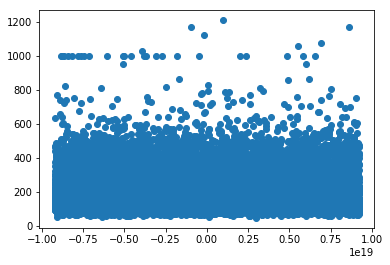

In [75]:
# evaluate results
plt.scatter(df.index, df.enc_score)

(array([2.465e+03, 7.873e+03, 3.777e+03, 2.221e+03, 1.856e+03, 1.227e+03,
        6.760e+02, 3.560e+02, 1.360e+02, 6.600e+01, 2.800e+01, 2.500e+01,
        1.500e+01, 7.000e+00, 2.000e+00, 2.000e+00, 2.500e+01, 2.000e+00,
        1.000e+00, 3.000e+00]),
 array([  46. ,  104.1,  162.2,  220.3,  278.4,  336.5,  394.6,  452.7,
         510.8,  568.9,  627. ,  685.1,  743.2,  801.3,  859.4,  917.5,
         975.6, 1033.7, 1091.8, 1149.9, 1208. ]),
 <a list of 20 Patch objects>)

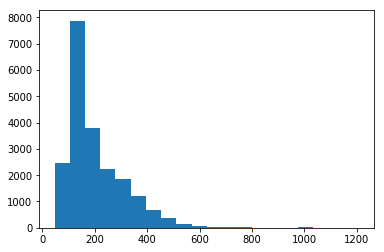

In [76]:
plt.hist(df.enc_score, bins=20)
# would be multimodal if not restircted to ARTICLEs

In [83]:
# 400 seems to be a valid limit. We don't loose too many good articles here (~6 %)
#df[df.enc_score.between(400, 500)][TEXT].tolist()
len(df[df.enc_score > 400]) / len(df)

0.060106920965178445

### collecting links from Wikipedia in a separate DataFrame

In [ ]:
# collecting links from Wikipedia in a separate DataFrame
LINK_LIST = []
TAGS_LIST = []

def collect_links(df):
    for doc_id, links in df[LINKS].iteritems():
        for link in links:
            LINK_LIST.append((doc_id, *link))

def collect_tags(df):
    for doc_id, categories in df[TAGS].iteritems():
        for category in categories:
            TAGS_LIST.append((doc_id, category))

pattern = re.compile(r'^dewiki_\d')
files = sorted([f for f in listdir(FULL_PATH)
                if isfile(join(FULL_PATH, f))
                and pattern.match(f)
               ])

for name in files:
    fname = join(ETL_PATH, name)
    print(fname)
    df = pd.read_pickle(fname)
    collect_links(df)
    collect_tags(df)

del df
df_links = pd.DataFrame.from_records(LINK_LIST, columns=['doc_id', 'link', 'norm', 'category'])
del LINK_LIST
df_tags = pd.DataFrame.from_records(TAGS_LIST, columns=['doc_id', 'category'])
del TAGS_LIST
df_links.to_pickle(join(ETL_PATH, 'dewiki_links.pickle'))
df_tags.to_pickle(join(ETL_PATH, 'dewiki_categories.pickle'))

### splitting the largest files from the wikipedia corpus to parallelize the nlp pipeline

In [ ]:
# splitting the largest files from the wikipedia corpus to parallelize the nlp pipeline
fname = 'dewiki_01.pickle'
fpath = join(ETL_PATH, fname)
df = pd.read_pickle(fpath)
split = 25*1000
#split *= 2
dfs = [df[:1*split], 
       #df[1*split:], 
       df[1*split:2*split], 
       df[2*split:3*split], 
       df[3*split:]
      ]
length = sum([len(d) for d in dfs])
assert len(df) == length
df.shape, [d.shape for d in dfs]
fsplit = fpath.rsplit('.', 1)
for i, d in enumerate(dfs):
    f = "{}_{:d}.{}".format(fsplit[0], i, fsplit[1])
    print(f)
    d.to_pickle(f)